# Significant Words

* Date: 18 August 2019
* Author: Rafael C. Alvarado
* Subject: Textual OEnolytics 

In this notebook we focus on the "unstructured data" contained in the wine reviews themselves. We explore some frequency-based measures for estimating the significance of words and bigrams in the corpus.


# Setup

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import plotly_express as px
from IPython.core.display import display, HTML

## Pragmas

In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

## Modify HTML styles

In [3]:
%%html
<style>
p {margin: rem; }
.large {font-size: 16pt;}
.readerly {font-size: 14pt; font-family: serif;}
div.title {font-weight:bold; margin-bottom:.5rem;}
</style>

In [4]:
def show(str, el='DIV', css_class=''):
    display(HTML("<{0} class='{1}'>{2}</{0}>".format(el, css_class, str)))

##  Import data

In [5]:
dbdir = '/Users/rca2t/CODE/polo2-test/PUB/winereviews/'
db = dbdir + 'winereviews-corpus.db'
with sqlite3.connect(db) as db:
    doc = pd.read_sql('select * from doc', db, index_col='doc_id')
    doctoken = pd.read_sql('select * from doctoken', db, index_col=['doc_id','sentence_id','token_ord'])
    vocab = pd.read_sql('select * from token', db, index_col='token_str')
    bigrams = pd.read_sql('select * from ngrambi', db, index_col='ngram')
    docbigrams = pd.read_sql('select * from ngrambidoc', db, index_col=['ngram','doc_id'])

# Vocabulary

## Signifant Words (Unigrams)

We use TFIDF to measure the significance of words in the corpus. TFIDF combines the frequency of a word in a document along with its overall frequency in the corpus. If a word is used all the time, it is considered insignificant. 

```
TF: Frequency of words in a document  
DF: Number of documents in which a word appears in the corpus  
IDF = 1 / DF  
N: Number of words in the corpus  
TFIDF = TF * log10(N/IDF)
```

We sum the TFIDF of each word across the corpus to get the most significant of words in the vocabulary.

Note that TFIDF is roughly equivalent to term frequecny divided by term entropy.

In [6]:
vocab.sort_values('tfidf_sum', ascending=False).head(20)[['tfidf_sum']].style.bar()

,tfidf_sum
token_str,
flavors,5162
fruit,4398.77
acidity,3933
aromas,3741.13
finish,3503.5
tannins,3363.64
ripe,3289.58
cherry,3068.26
black,2866.86


# Bigrams

We look at word pairs.

## Bigram Frequency

In [7]:
bigrams.sort_values('freq', ascending=False).freq.to_frame().head(20).style.bar()

,freq
ngram,
black_cherry,7438
fruit_flavors,5692
cabernet_sauvignon,5025
pinot_noir,3124
black_pepper,2765
white_pepper,2535
black_currant,2447
cabernet_franc,2375
black_fruit,2355


## Bigram  Entropy

In [8]:
bigrams.sort_values('entropy', ascending=False).entropy.to_frame().head(20).style.bar()

,entropy
ngram,
mouth_flavors,2.7729
finish_bright,2.5653
zesty_finish,2.55594
lead_flavors,2.54491
finish_crisp,2.50628
nose_cherry,2.5062
bright_finish,2.48041
flavors_peach,2.4731
nose_fresh,2.44852


## Bigram TFIDF

NOTE TO SELF: This should be computed by Polo.

In [9]:
# docbigrams['tp'] = docbigrams['tf'] / docbigrams.groupby('doc_id')['tf'].count()
# docbigrams['tfidf'] = docbigrams['tp'] * bigrams['idf']
docbigrams['tfidf'] = (docbigrams['tf'] / docbigrams.groupby('doc_id')['tf'].count()) * bigrams['idf']
bigrams['tfidf_sum'] = docbigrams.groupby('ngram').tfidf.sum()

In [10]:
bigrams.tfidf_sum.sort_values(ascending=False).head(20).to_frame().style.bar()

,tfidf_sum
ngram,
black_cherry,406.699
fruit_flavors,403.801
cabernet_sauvignon,307.431
pinot_noir,246.105
black_currant,216.66
crisp_acidity,215.767
firm_tannins,211.004
red_fruits,209.672
red_berry,201.698


##  Bigram TFTR (experimental)

A new measure -- Term Frequency Term Redundancy

`R = 1 - (H / Hmax)`

In [11]:
max_entropy = (1 / bigrams.shape[0]) * np.log2(bigrams.shape[0])
bigrams['redundancy'] = 1 - (bigrams['entropy'] / max_entropy)
docbigrams['tfidh'] = (docbigrams['tf'] / docbigrams.groupby('doc_id')['tf'].count()) * bigrams['redundancy']
bigrams['tfidh_sum'] = docbigrams.groupby('ngram').tfidh.sum() * -1

In [12]:
bigrams['tfidh_sum'].sort_values(ascending=False).to_frame().head(20).style.bar()

,tfidh_sum
ngram,
black_cherry,2.05757e+07
fruit_flavors,1.77852e+07
cabernet_sauvignon,1.26472e+07
black_fruit,8.31846e+06
green_apple,8.02438e+06
berry_flavors,7.85549e+06
black_currant,7.73657e+06
firm_tannins,7.7323e+06
red_berry,7.72056e+06


In [13]:
# px.scatter(bigrams, 'tfidf_sum', 'tfidh_sum', trendline='lowess')

# Words associated with Good and Bad wines

Select the review with high and low ratings, using the 80th and 20th percentiles respectively.

## Convert points into grades (A and B) 

In [14]:
doc.loc[doc.doc_points < doc.doc_points.quantile(.2), 'grade'] = 'B'
doc.loc[doc.doc_points > doc.doc_points.quantile(.8), 'grade'] = 'A'
doc['grade'] = doc['grade'].fillna('N')

In [15]:
Amin =  doc.loc[doc.grade == 'A'].doc_points.min()
Bmax = doc.loc[doc.grade == 'B'].doc_points.max()

In [16]:
show("Grade A >= {}<br/>Grade B <= {}".format(Amin, Bmax), css_class='large')

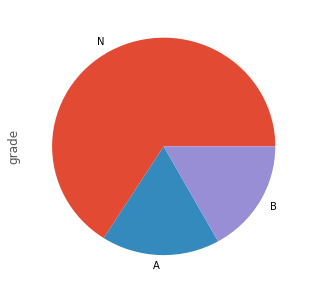

In [17]:
doc.grade.value_counts().plot(kind='pie', figsize=(5,5))

## Apply doc grades to words

In [18]:
dtg = doctoken.join(doc['grade'], on='doc_id', how='inner')
dtg.index.names  = ['doc_id', 'sentence_id', 'token_ord'] # Because doc_id gets lost for some reason

In [19]:
dtg.head()

token_str  pos grade
doc_id sentence_id token_ord                     
0      0           0            aromas  NNP     N
                   1           include  VBP     N
                   2          tropical   JJ     N
                   3             fruit   NN     N
                   5             broom   NN     N

##  Find words strongly associated with each grade

In [20]:
G = dtg.groupby(['grade', 'token_str']).count().unstack().fillna(0).T
G.index = G.index.droplevel(0)
G = G / G.sum()

In [21]:
G['A'].sort_values(ascending=False).head(10)

token_str
flavors    0.014952
fruit      0.013595
tannins    0.010961
black      0.010886
acidity    0.009862
ripe       0.009394
aromas     0.008542
cherry     0.008343
finish     0.008268
rich       0.007826
Name: A, dtype: float64

In [22]:
G['B'].sort_values(ascending=False).head(10)

token_str
flavors    0.030583
aromas     0.016396
finish     0.015523
fruit      0.015285
acidity    0.012594
cherry     0.008583
soft       0.008160
sweet      0.008130
tannins    0.007515
red        0.007362
Name: B, dtype: float64

In [23]:
G['x'] = G.A - G.B

### Top words associated with A wines

In [24]:
G.x.sort_values(ascending=False).head(10).to_frame().style.bar()

,x
token_str,
black,0.00675246
rich,0.00569024
years,0.00435106
ripe,0.00369491
dark,0.00363941
tannins,0.00344608
concentrated,0.00327535
vineyard,0.00297792
complex,0.00290389


###  Top words associated with B wines

In [25]:
G.x.sort_values(ascending=True).head(10).to_frame().style.bar()

,x
token_str,
flavors,-0.0156308
aromas,-0.00785379
finish,-0.00725458
soft,-0.00584905
simple,-0.0053682
light,-0.00522807
sweet,-0.0051287
green,-0.00443742
fruity,-0.00393174


## Do the same for bigrams

In [26]:
docbigrams = docbigrams.reset_index().set_index(['doc_id', 'ngram']).sort_index()

In [27]:
dbg = docbigrams.join(doc['grade'], on='doc_id', how='inner')
dbg.index.names  = ['doc_id', 'ngram'] # Because doc_id gets lost

In [28]:
dbg.head()

tf     tfidf        tfidh grade
doc_id ngram                                           
0      alongside_brisk   1  0.171586  -204.227557     N
       apple_citrus      1  0.130044 -4812.178050     N
       aromas_include    1  0.140909 -2909.611652     N
       brimstone_dried   1  0.267379     0.055556     N
       brisk_acidity     1  0.121700 -2495.545302     N

In [29]:
G1 = dbg.groupby(['grade', 'ngram']).tfidh.count().unstack().fillna(0).T
G1 = G1 / G1.sum()

In [30]:
G1.A.sort_values(ascending=False).to_frame().head(10)

,A
ngram,
black_cherry,0.003192
cabernet_sauvignon,0.001921
fruit_flavors,0.001488
white_pepper,0.001319
black_pepper,0.001319
black_fruits,0.001210
pinot_noir,0.001199
dark_chocolate,0.001067
black_currant,0.001016


In [31]:
G1.B.sort_values(ascending=False).to_frame().head(10)

,B
ngram,
fruit_flavors,0.002153
berry_flavors,0.001332
cabernet_sauvignon,0.001300
flavors_finish,0.001271
pinot_noir,0.001237
sauvignon_blanc,0.001137
black_cherry,0.001091
aromas_flavors,0.001074
red_fruit,0.001051


In [32]:
G1['x'] = G1.A - G1.B

### Top bigrams associated with A wines

In [33]:
G1.x.sort_values(ascending=False).to_frame().head(30).style.bar()

,x
ngram,
black_cherry,0.00210073
white_pepper,0.000963678
black_pepper,0.000909269
dark_chocolate,0.000867034
black_fruits,0.000843514
long_finish,0.000683264
cabernet_sauvignon,0.000621047
still_young,0.000599261
baking_spice,0.000591812


### Top bigrams associated with B wines

In [34]:
G1.x.sort_values(ascending=True).to_frame().head(20).style.bar()

,x
ngram,
flavors_finish,-0.000998771
berry_flavors,-0.00098584
sauvignon_blanc,-0.000882003
aromas_flavors,-0.000779798
fruit_flavors,-0.000665356
berry_aromas,-0.000654134
cherry_flavors,-0.000620184
tropical_fruit,-0.00060454
red_fruit,-0.000576896


In [35]:
G1['A_z'] = (G1.A - G1.A.mean()) / G1.A.std()

In [36]:
G1['B_z'] = (G1.B - G1.B.mean()) / G1.B.std()

In [37]:
G1['x_z'] = (G1.x - G1.x.mean()) / G1.x.std()

In [38]:
n = 20
Au = G.x.sort_values(ascending=False).head(n).to_frame().reset_index().rename(columns={'x':'A', 'token_str':'unigram'})
Ab = G1.x.sort_values(ascending=False).head(n).to_frame().reset_index().rename(columns={'x':'A', 'ngram':'bigram'})
Bu = G.x.sort_values(ascending=True).head(n).to_frame().reset_index().rename(columns={'x':'B',  'token_str':'unigram'})
Bb = G1.x.sort_values(ascending=True).head(n).to_frame().reset_index().rename(columns={'x':'B', 'ngram':'bigram'})

In [39]:
E = pd.concat([Au,Ab,Bu,Bb], 1, sort=False)

In [40]:
E

,unigram,A,bigram,A,unigram,B,bigram,B
0,black,0.006752,black_cherry,0.002101,flavors,-0.015631,flavors_finish,-0.000999
1,rich,0.005690,white_pepper,0.000964,aromas,-0.007854,berry_flavors,-0.000986
2,years,0.004351,black_pepper,0.000909,finish,-0.007255,sauvignon_blanc,-0.000882
3,ripe,0.003695,dark_chocolate,0.000867,soft,-0.005849,aromas_flavors,-0.000780
4,dark,0.003639,black_fruits,0.000844,simple,-0.005368,fruit_flavors,-0.000665
5,tannins,0.003446,long_finish,0.000683,light,-0.005228,berry_aromas,-0.000654
6,concentrated,0.003275,cabernet_sauvignon,0.000621,sweet,-0.005129,cherry_flavors,-0.000620
7,vineyard,0.002978,still_young,0.000599,green,-0.004437,tropical_fruit,-0.000605
8,complex,0.002904,baking_spice,0.000592,fruity,-0.003932,red_fruit,-0.000577
9,firm,0.002825,velvety_tannins,0.000582,crisp,-0.003359,slightly_sweet,-0.000570


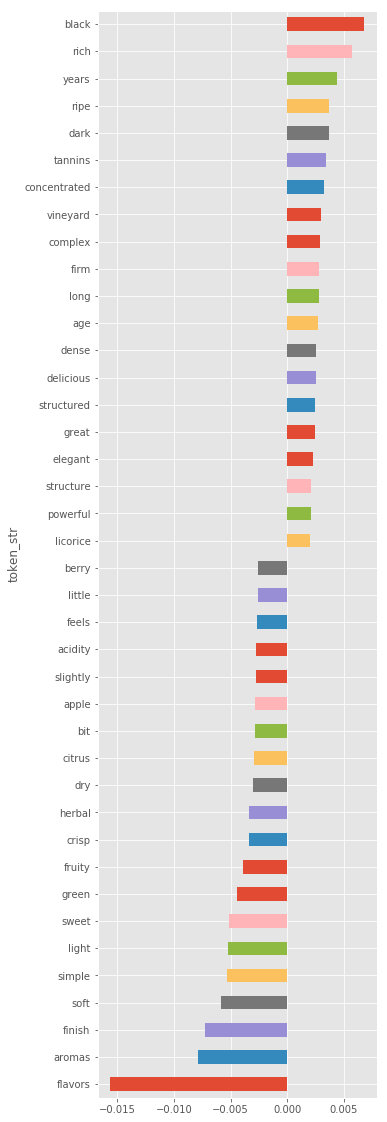

In [41]:
pd.concat([G.x.sort_values(ascending=True).head(20), 
          G.x.sort_values(ascending=True).tail(20)]).plot(kind='barh', figsize=(5,20))

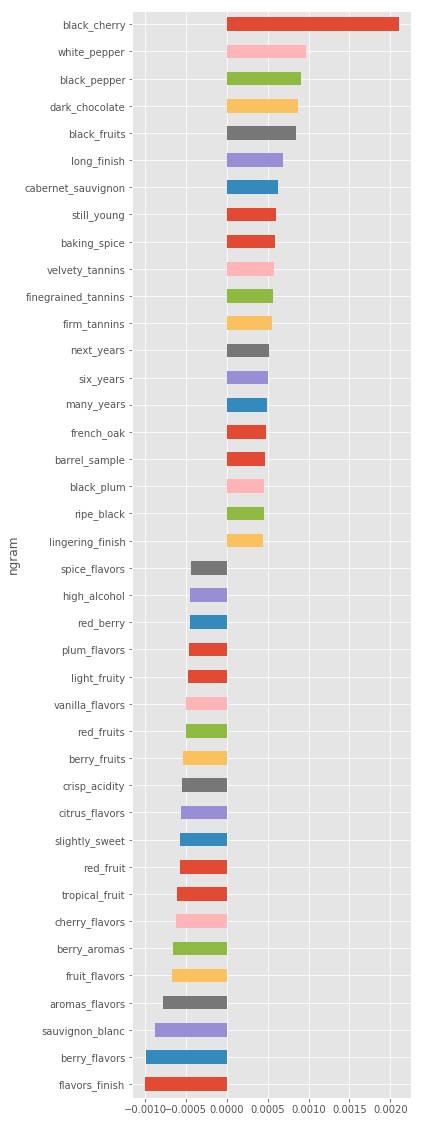

In [42]:
pd.concat([G1.x.sort_values(ascending=True).head(20), 
          G1.x.sort_values(ascending=True).tail(20)]).plot(kind='barh', figsize=(5,20))

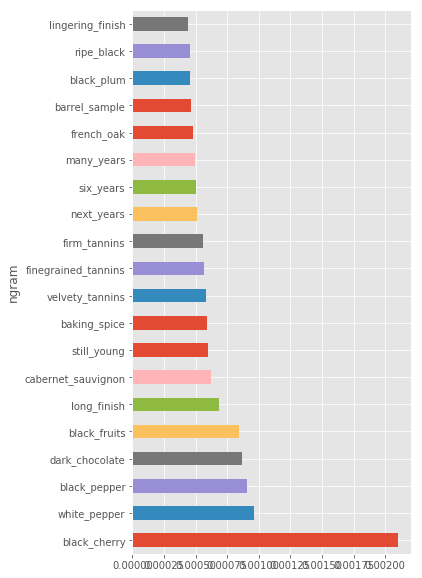

In [43]:
G1.x.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(5,10))

# Conclusions

**Words and prhases to use when tasting wines**

* finish, acidity, aromas, tannis, ripeness
* black cherry, crisp acitiy, firm tannins, black pepper, white pepper 

In [44]:
G.to_csv('winereview-vocab.csv')
G1.to_csv('winereview-bigrams.csv')

In [45]:
# END